In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import data_tool as dt

In [2]:
user_number = 100
code_length = 50
epoch_number = 30
batch_size = 1000

In [3]:
class NMSE_Accuracy(keras.metrics.Metric):
    def __init__(self, name="nmse_accuracy", **kwargs):
        super(NMSE_Accuracy, self).__init__(name=name, **kwargs)
        self.sum_nmse = self.add_weight(name="sum_nmse", initializer="zeros")
        self.sample_number = self.add_weight(name="sample_number", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        diff = y_pred - y_true
        fenmu = tf.reduce_sum(tf.pow(y_true, 2), 1)
        current_nmse = tf.reduce_sum(tf.reduce_sum(tf.pow(diff, 2), 1) / fenmu)
        current_nmse = tf.where(tf.math.is_nan(current_nmse)|tf.math.is_inf(current_nmse), tf.zeros_like(current_nmse), current_nmse)
        current_nmse = tf.cast(current_nmse, "float32")
        self.sum_nmse.assign_add(current_nmse)
#         current_sample_number = y_true.shape[0]
        current_sample_number = tf.math.count_nonzero(fenmu)
        current_sample_number = tf.cast(current_sample_number, "float32")
        self.sample_number.assign_add(current_sample_number)

    def result(self):
        return 10 * (tf.math.log(self.sum_nmse / self.sample_number) / tf.math.log(10.))

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.sum_nmse.assign(0.0)
        self.sample_number.assign(0.0)



In [4]:
estimator = keras.Sequential(
    [
        tf.keras.layers.BatchNormalization(name="bp1"),
        layers.Dense(user_number + code_length, activation="relu", name="layer1"),
        tf.keras.layers.BatchNormalization(name="bp2"),
        layers.Dense(user_number + code_length, activation="relu", name="layer2"),
        tf.keras.layers.BatchNormalization(name="bp3"),
        layers.Dense(user_number + code_length, activation="relu", name="layer3"),
        tf.keras.layers.BatchNormalization(name="pb4"),
        layers.Dense(user_number, activation="relu", name="layer4"),
    ],name = 'estimator'
)
# Call model on a test input
y = tf.ones((3, code_length))
x_hat = estimator(y)
estimator.summary()

Model: "estimator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bp1 (BatchNormalization)     (3, 50)                   200       
_________________________________________________________________
layer1 (Dense)               (3, 150)                  7650      
_________________________________________________________________
bp2 (BatchNormalization)     (3, 150)                  600       
_________________________________________________________________
layer2 (Dense)               (3, 150)                  22650     
_________________________________________________________________
bp3 (BatchNormalization)     (3, 150)                  600       
_________________________________________________________________
layer3 (Dense)               (3, 150)                  22650     
_________________________________________________________________
pb4 (BatchNormalization)     (3, 150)                  60

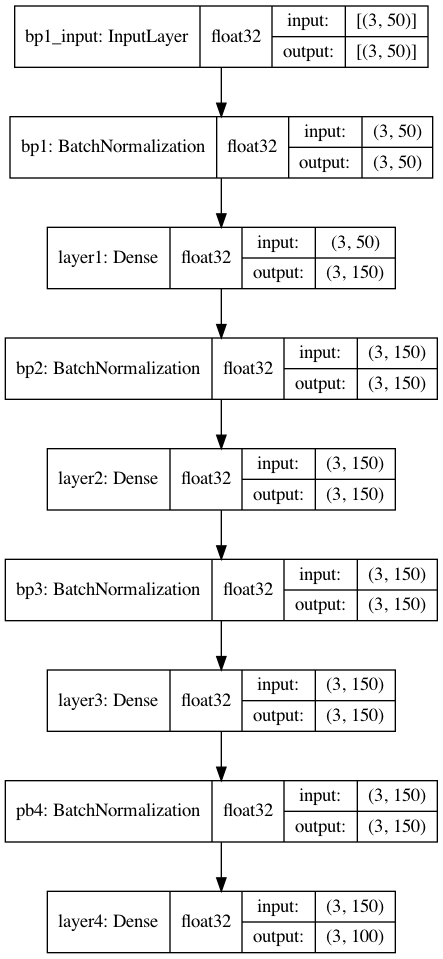

In [5]:
keras.utils.plot_model(estimator, "./temp/3_re.png", show_shapes=True, show_dtype=True)

In [6]:
signature_matrix = dt.get_random_binary_signature_matrix(user_number, code_length)
y_set, x_set, h_set = dt.get_dataset(1000000, signature_matrix, is_fading=1)
y_set = y_set.astype("float32")
x_set = x_set.astype("float32")
h_set = h_set.astype("float32")
y_test, x_test, h_test = dt.get_dataset(10000, signature_matrix, is_fading=1)
y_test = y_test.astype("float32")
x_test = x_test.astype("float32")
h_test = h_test.astype("float32")

In [7]:
estimator.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.RMSprop(),
    metrics=NMSE_Accuracy(),
)

history = estimator.fit(y_set, h_set, batch_size=1000, epochs=30, validation_split=0.2)

test_scores = estimator.evaluate(y_test, h_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/30
800/800 [==============================] - 11s 12ms/step - loss: 0.1094 - nmse_accuracy: -3.2510 - val_loss: 0.0194 - val_nmse_accuracy: -10.7738
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0142 - nmse_accuracy: -12.1395 - val_loss: 0.0103 - val_nmse_accuracy: -13.6376
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0099 - nmse_accuracy: -13.7263 - val_loss: 0.0086 - val_nmse_accuracy: -14.4370
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0086 - nmse_accuracy: -14.3747 - val_loss: 0.0079 - val_nmse_accuracy: -14.8482
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0080 - nmse_accuracy: -14.7383 - val_loss: 0.0074 - val_nmse_accuracy: -15.1314
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0076 - nmse_accuracy: -14.9293 - val_loss: 0.0072 - val_nmse_accuracy: -15.2447
Epoch 7/30
800/800 [==============================] - 9s 1

In [9]:
detector = keras.Sequential(
    [
        tf.keras.layers.BatchNormalization(name="bp1"),
        layers.Dense(user_number + code_length, activation="relu", name="layer1"),
        tf.keras.layers.BatchNormalization(name="bp2"),
        layers.Dense(user_number + code_length, activation="relu", name="layer2"),
        tf.keras.layers.BatchNormalization(name="bp3"),
        layers.Dense(user_number + code_length, activation="relu", name="layer3"),
        tf.keras.layers.BatchNormalization(name="pb4"),
        layers.Dense(user_number, activation="sigmoid", name="layer4"),
    ],name = 'detector'
)
# Call model on a test input
y = tf.ones((3, code_length))
x_hat = detector(y)
detector.summary()

Model: "detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bp1 (BatchNormalization)     (3, 50)                   200       
_________________________________________________________________
layer1 (Dense)               (3, 150)                  7650      
_________________________________________________________________
bp2 (BatchNormalization)     (3, 150)                  600       
_________________________________________________________________
layer2 (Dense)               (3, 150)                  22650     
_________________________________________________________________
bp3 (BatchNormalization)     (3, 150)                  600       
_________________________________________________________________
layer3 (Dense)               (3, 150)                  22650     
_________________________________________________________________
pb4 (BatchNormalization)     (3, 150)                  600

In [10]:
detector.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.RMSprop(),
    metrics="accuracy",
)

history = detector.fit(y_set, x_set, batch_size=1000, epochs=30, validation_split=0.2)

test_scores = detector.evaluate(y_test, x_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/30
800/800 [==============================] - 12s 13ms/step - loss: 0.1010 - accuracy: 0.1046 - val_loss: 0.0275 - val_accuracy: 0.1257
Epoch 2/30
800/800 [==============================] - 10s 13ms/step - loss: 0.0235 - accuracy: 0.1206 - val_loss: 0.0182 - val_accuracy: 0.1203
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0175 - accuracy: 0.1226 - val_loss: 0.0160 - val_accuracy: 0.1463
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0156 - accuracy: 0.1479 - val_loss: 0.0148 - val_accuracy: 0.1707
Epoch 5/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0147 - accuracy: 0.1803 - val_loss: 0.0142 - val_accuracy: 0.2067
Epoch 6/30
800/800 [==============================] - 10s 13ms/step - loss: 0.0142 - accuracy: 0.2071 - val_loss: 0.0138 - val_accuracy: 0.2297
Epoch 7/30
800/800 [==============================] - 10s 13ms/step - loss: 0.0138 - accuracy: 0.2300 - val_loss: 0.0135 - val_accuracy: 0

In [26]:
m = detector(y_set[0:1,:])

In [14]:
x_set[0:1,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]], dtype=float32)

In [72]:
i = 10
m = detector(y_set[0:i,:])
threshould = 0.5
tf.math.count_nonzero(tf.ones_like(m)*[m>threshould]-x_set[0:i,:]) / (i * 100)

<tf.Tensor: shape=(), dtype=float64, numpy=0.025>

In [77]:
i = 10000
mm = estimator(y_set[0:i,:])
threshould = 0.001
tf.math.count_nonzero(tf.ones_like(mm)*[mm>threshould]-x_set[0:i,:]) / (i * 100)

<tf.Tensor: shape=(), dtype=float64, numpy=0.051014>

In [105]:
tf.multiply(tf.ones_like(mm),(mm>threshould).numpy())

<tf.Tensor: shape=(10000, 100), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [111]:
tf.multiply(tf.ones_like(mm),tf.cast(mm>threshould, "float32"))

<tf.Tensor: shape=(10000, 100), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [89]:
tf.math.count_nonzero(tf.ones_like(mm)*(x_set[0:i,:]>0) - tf.ones_like(mm)*(h_set[0:i,:]>0))

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [94]:
[mm>threshould]

<tf.Tensor: shape=(10000, 100), dtype=bool, numpy=
array([[False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])>

In [98]:
tf.ones_like(mm)*(x_set[0:i,:]>0)

<tf.Tensor: shape=(10000, 100), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [124]:
tf.math.count_nonzero(tf.reduce_sum(x_set[0:i,:],1))

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [102]:
mm>threshould

<tf.Tensor: shape=(10000, 100), dtype=bool, numpy=
array([[False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])>

In [117]:
b = mm.numpy().size

In [118]:
b

1000000

In [119]:
tf.cast(b, "float32")

<tf.Tensor: shape=(), dtype=float32, numpy=1000000.0>